In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [95]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [96]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# Data preprocessing

In [97]:
df = pd.concat([train, test], axis=0)
df.shape

(2919, 81)

In [98]:
df = df.drop('Id', axis=1, errors='ignore')

At the first sight, the null values can be observed, let's check the percentage of them in each column:

In [99]:
df.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
Street              0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 80, dtype: int64

In [100]:
columns_with_nulls = df.columns[df.isnull().any()]
total_rows = df.shape[0]

null_percentages = (df[columns_with_nulls].isnull().sum() / total_rows) * 100


print("Percentage of null values in each column that has nulls:")
null_percentages

Percentage of null values in each column that has nulls:


MSZoning         0.137033
LotFrontage     16.649538
Alley           93.216855
Utilities        0.068517
Exterior1st      0.034258
Exterior2nd      0.034258
MasVnrType       0.822199
MasVnrArea       0.787941
BsmtQual         2.774923
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtFinType1     2.706406
BsmtFinSF1       0.034258
BsmtFinType2     2.740665
BsmtFinSF2       0.034258
BsmtUnfSF        0.034258
TotalBsmtSF      0.034258
Electrical       0.034258
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
KitchenQual      0.034258
Functional       0.068517
FireplaceQu     48.646797
GarageType       5.378554
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageCars       0.034258
GarageArea       0.034258
GarageQual       5.447071
GarageCond       5.447071
PoolQC          99.657417
Fence           80.438506
MiscFeature     96.402878
SaleType         0.034258
SalePrice       49.982871
dtype: float64

Columns that has above 80% of missing values can be just droped from the data set:

In [101]:
columns_to_drop = null_percentages[null_percentages > 80.0].index
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [102]:
df.shape

(2919, 76)

In [103]:
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = numeric_cols.drop('SalePrice')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median()) #fills the missing values in these numeric columns with the median value

categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0]) #fills the missing values in these categorical columns with the most frequent value

Since there is no null values, we can focus on the target values distribution:

<Axes: xlabel='SalePrice', ylabel='Count'>

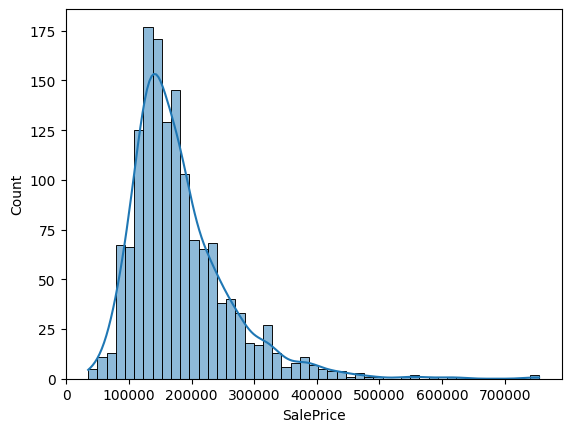

In [104]:
sns.histplot(train['SalePrice'], kde=True)

The histogram confirm that our data set is positively skewed, so the log transform will be applied later.

In [105]:
df.tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1449,180,RM,21.0,1470,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Normal,NaN
1450,160,RM,21.0,1484,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,5,2006,WD,Normal,NaN
1451,20,RL,80.0,13384,Pave,Reg,Lvl,AllPub,Inside,Mod,...,0,0,0,0,0,5,2006,WD,Normal,NaN
1452,160,RM,21.0,1533,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,12,2006,WD,Abnorml,NaN
1453,160,RM,21.0,1526,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,NaN
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,NaN
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,4,2006,WD,Abnorml,NaN
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2006,WD,Abnorml,NaN
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,700,7,2006,WD,Normal,NaN
1458,60,RL,74.0,9627,Pave,Reg,Lvl,AllPub,Inside,Mod,...,0,0,0,0,0,11,2006,WD,Normal,NaN


**Feature encoding:**

In [106]:
categorical_cols

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [107]:
df = pd.get_dummies(df, columns=categorical_cols)

In [108]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0


**Adding new feature to the data set:**

Since the data set has 'YearBuilt' as well as 'YrSold' columns, I've decided to add new column indicating the age of house( sold year - build year )

In [109]:
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,1,0,5
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,1,0,31
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,1,0,7
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,1,0,0,0,0,0,91
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,1,0,8


**Feature standarization:**

In [110]:
numeric_cols #target 'SalePrice' have been droped earlier from this list

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [111]:
scaler = StandardScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge
0,0.067331,-0.191815,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.580959,-0.293025,...,0,0,1,0,0,0,0,1,0,5
1,-0.873616,0.511940,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178162,-0.293025,...,0,0,1,0,0,0,0,1,0,31
2,0.067331,-0.051064,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.097928,-0.293025,...,0,0,1,0,0,0,0,1,0,7
3,0.302568,-0.426400,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494884,-0.293025,...,0,0,1,1,0,0,0,0,0,91
4,0.067331,0.699608,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,0.468984,-0.293025,...,0,0,1,0,0,0,0,1,0,8
5,-0.167905,0.746525,0.500515,-0.772552,-0.507284,0.716075,0.513889,-0.567016,0.638045,-0.293025,...,0,0,1,0,0,0,0,1,0,16
6,-0.873616,0.277355,-0.010667,1.355551,-0.507284,1.079276,0.992569,0.473113,2.036641,-0.293025,...,0,0,1,0,0,0,0,1,0,3
7,0.067331,-0.051064,0.027123,0.646183,0.391237,0.055709,-0.539208,0.775086,0.916886,-0.103844,...,0,0,1,0,0,0,0,1,0,36
8,-0.167905,-0.848652,-0.513352,0.646183,-0.507284,-1.331059,-1.640173,-0.567016,-0.969133,-0.293025,...,0,0,1,1,0,0,0,0,0,77
9,3.125411,-0.895569,-0.348496,-0.772552,0.391237,-1.066912,-1.640173,-0.567016,0.899321,-0.293025,...,0,0,1,0,0,0,0,1,0,69


**Train test split:**

At the beggining we assumed that the data is positively skewed, so we will now apply the log transform to the target.

In [112]:
X_train = df[:train.shape[0]]
y_train = np.log1p(train['SalePrice'])

In [113]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,HouseAge
0,0.067331,-0.191815,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.580959,-0.293025,...,0,0,1,0,0,0,0,1,0,5
1,-0.873616,0.511940,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178162,-0.293025,...,0,0,1,0,0,0,0,1,0,31
2,0.067331,-0.051064,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.097928,-0.293025,...,0,0,1,0,0,0,0,1,0,7
3,0.302568,-0.426400,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494884,-0.293025,...,0,0,1,1,0,0,0,0,0,91
4,0.067331,0.699608,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,0.468984,-0.293025,...,0,0,1,0,0,0,0,1,0,8


In [114]:
y_train.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

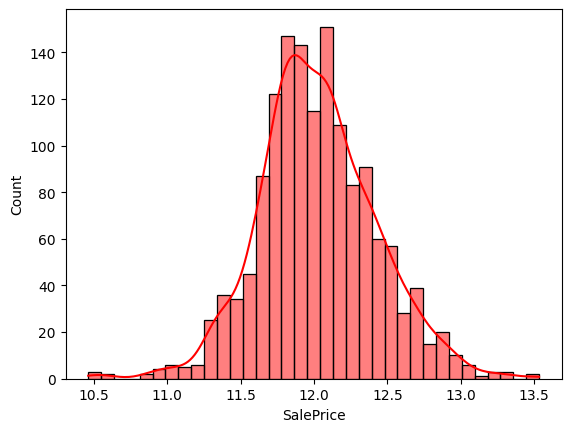

In [115]:
sns.histplot(y_train, kde=True, color = 'r')

Ridge regression with regularization to prevent overfitting in linear regression models since overfitting happened while previously evaluating the model.

In [ ]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred_train_ridge = ridge_model.predict(X_train)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_pred_train_ridge))

print("Training RMSE:", train_rmse_ridge)